In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tmdb-box-office-prediction/sample_submission.csv
/kaggle/input/tmdb-box-office-prediction/train.csv
/kaggle/input/tmdb-box-office-prediction/test.csv


In [2]:
train_df = pd.read_csv('/kaggle/input/tmdb-box-office-prediction/train.csv')
test_df = pd.read_csv('/kaggle/input/tmdb-box-office-prediction/test.csv')
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

# Baseline

In [3]:
from sklearn.ensemble import RandomForestRegressor

# Velger budsjett og popularitet for baseline
X_train, y_train = train_df.to_numpy()[:, [2, 9]], train_df.to_numpy()[:, -1]
model_rf = RandomForestRegressor().fit(X_train, y_train)


from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# Beregner RMSLE
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true.astype(float)))))

rmsle_scorer = make_scorer(rmsle)
cv_scores = cross_val_score(model_rf, X_train, y_train, cv=5, scoring=rmsle_scorer, n_jobs=-1)

print(cv_scores)
print(cv_scores.mean())

[2.75330136 2.74167561 2.62858725 2.63644303 2.44160989]
2.6403234297891087


* En enkel modell basert på budsjett og popularitet skårer 2,64 i RMSLE.

# Feature engineering

In [4]:
import ast


def data_preparation(df):

    #Transformerer data til tall.
    df['belongs_to_collection'] = df['belongs_to_collection'].notna()
    df['homepage'] = df['homepage'].notna()
    df['tagline'] = df['tagline'].notna()
    
    df['Keywords'] = df['Keywords'].fillna('[]').apply(ast.literal_eval)
    df['Keywords'] = df['Keywords'].apply(len)
    
    df['cast'] = df['cast'].fillna('[]').apply(ast.literal_eval)
    df['cast'] = df['cast'].apply(len)
    df['crew'] = df['crew'].fillna('[]').apply(ast.literal_eval)
    df['crew'] = df['crew'].apply(len)
    
    df['release_date'] = df['release_date'].fillna('1/1/00')
    df['year'] = pd.to_datetime(df['release_date'], format='%m/%d/%y').dt.year
    df['year'] = np.where(df['year'] > 2020, df['year'] - 100, df['year'])
    df['month'] = pd.to_datetime(df['release_date'], format='%m/%d/%y').dt.month
    df['day'] = pd.to_datetime(df['release_date'], format='%m/%d/%y').dt.dayofweek
    
    df['spoken_languages'] = df['spoken_languages'].fillna('[]').apply(ast.literal_eval)
    df['spoken_languages'] = df['spoken_languages'].apply(len)
    
    df['english'] = df['original_language'] == 'en'
    df['production_countries'] = df['production_countries'].fillna('[]').apply(ast.literal_eval)
    df['us_production'] = df['production_countries'].apply(lambda x: any(country['iso_3166_1'] == 'US' for country in x))
    df['production_countries'] = df['production_countries'].apply(len)

    
    #One-hot-encoding    
    def one_hot_encoding(df, feature, key):
        
        # Convert string representation of list of dictionaries to actual list of dictionaries
        df[feature] = df[feature].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])

        # Getting unique genre names
        unique_genres = set()
        for index, row in df.iterrows():
            for genre in row[feature]:
                unique_genres.add(genre[key])

        # Create a dictionary to store one-hot-encoded values
        encoded_genres = {}
        for genre in unique_genres:
            encoded_genres[genre] = df[feature].apply(lambda x: int(any(g[key] == genre for g in x)))

        # Concatenate the one-hot-encoded columns to the DataFrame
        df = pd.concat([df] + [pd.Series(encoded_genres[genre], name=genre) for genre in unique_genres], axis=1)

        # Dropping the original 'genres' column
        df.drop(feature, axis=1, inplace=True)
        
        return df
        
    df = one_hot_encoding(df, 'genres', 'name')
    df = one_hot_encoding(df, 'production_companies', 'name')
    
    
    # Boolske verdier settes til 1/0
    boolean_columns = df.select_dtypes(include='bool').columns
    df[boolean_columns] = df[boolean_columns].astype(int)
    
    
    # Dropper features
    df = df.select_dtypes(include=[np.number]) # Fjerner features som ikke er tall.
    true_counts = df.sum() # Fjerner features med få verdier.
    df.drop(columns=true_counts[true_counts < 10].index, inplace=True)
    
    
    # Setter manglende data til median
    df = df.fillna(df.median())
    
    
    # Flytter revenue til siste kolonne
    if 'revenue' in df.columns:
        column = df.pop('revenue')
        df['revenue'] = column
    
    
    return df


train_df = data_preparation(train_df)

/tmp/ipykernel_20/2243087157.py:81: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['revenue'] = column


# Statistikk for data

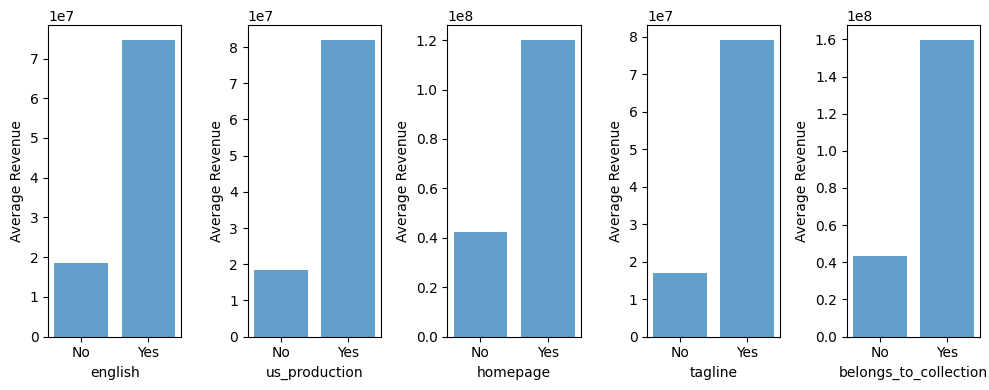

In [5]:
import matplotlib.pyplot as plt

cols_to_plot = [
    'english', 'us_production', 'homepage', 'tagline', 'belongs_to_collection', 'revenue'
]

train_plot_df = train_df[cols_to_plot]

# Convert categorical columns to numerical for plotting
train_plot_df = train_plot_df.applymap(lambda x: 0 if pd.isnull(x) else 1)

fig, axs = plt.subplots(1, 5, figsize=(10, 4))

# Reshape the axs object to flatten it
axs = axs.ravel()

for i, col in enumerate(train_plot_df.columns[:-1]):
    avg_revenue = train_df.groupby(col)['revenue'].mean()
    labels = ['No', 'Yes']
    x = range(len(labels))

    axs[i].bar(x, avg_revenue, alpha=0.7)
    axs[i].set_ylabel('Average Revenue')
    axs[i].set_xlabel(col)
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(labels)

plt.tight_layout()
plt.show()

* Filmer på engelsk har høyere inntekter.
* Filmer uten nettside og tagline har typisk lavere inntekter.
* Oppfølgere har høyere inntekter, kanskje er den første filmen en suksess om den får en oppfølger?

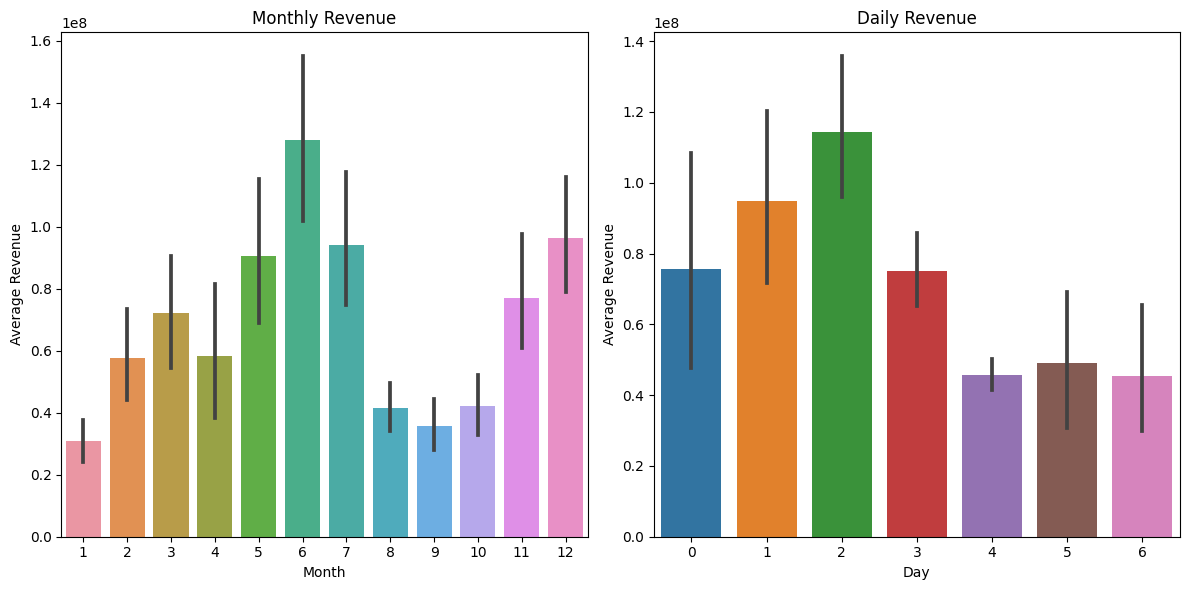

In [6]:
import seaborn as sns

# Create a figure and two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first bar plot (Month vs. Revenue)
sns.barplot(x=train_df['month'], y=train_df['revenue'], ax=axes[0])
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Average Revenue')
axes[0].set_title('Monthly Revenue')

# Plot the second bar plot (Day vs. Revenue)
sns.barplot(x=train_df['day'], y=train_df['revenue'], ax=axes[1])
axes[1].set_xlabel('Day')
axes[1].set_ylabel('Average Revenue')
axes[1].set_title('Daily Revenue')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

* Både enkelte måneder og dager er forbundet med høyere innteker, kanskje lanseres storproduksjoner her?

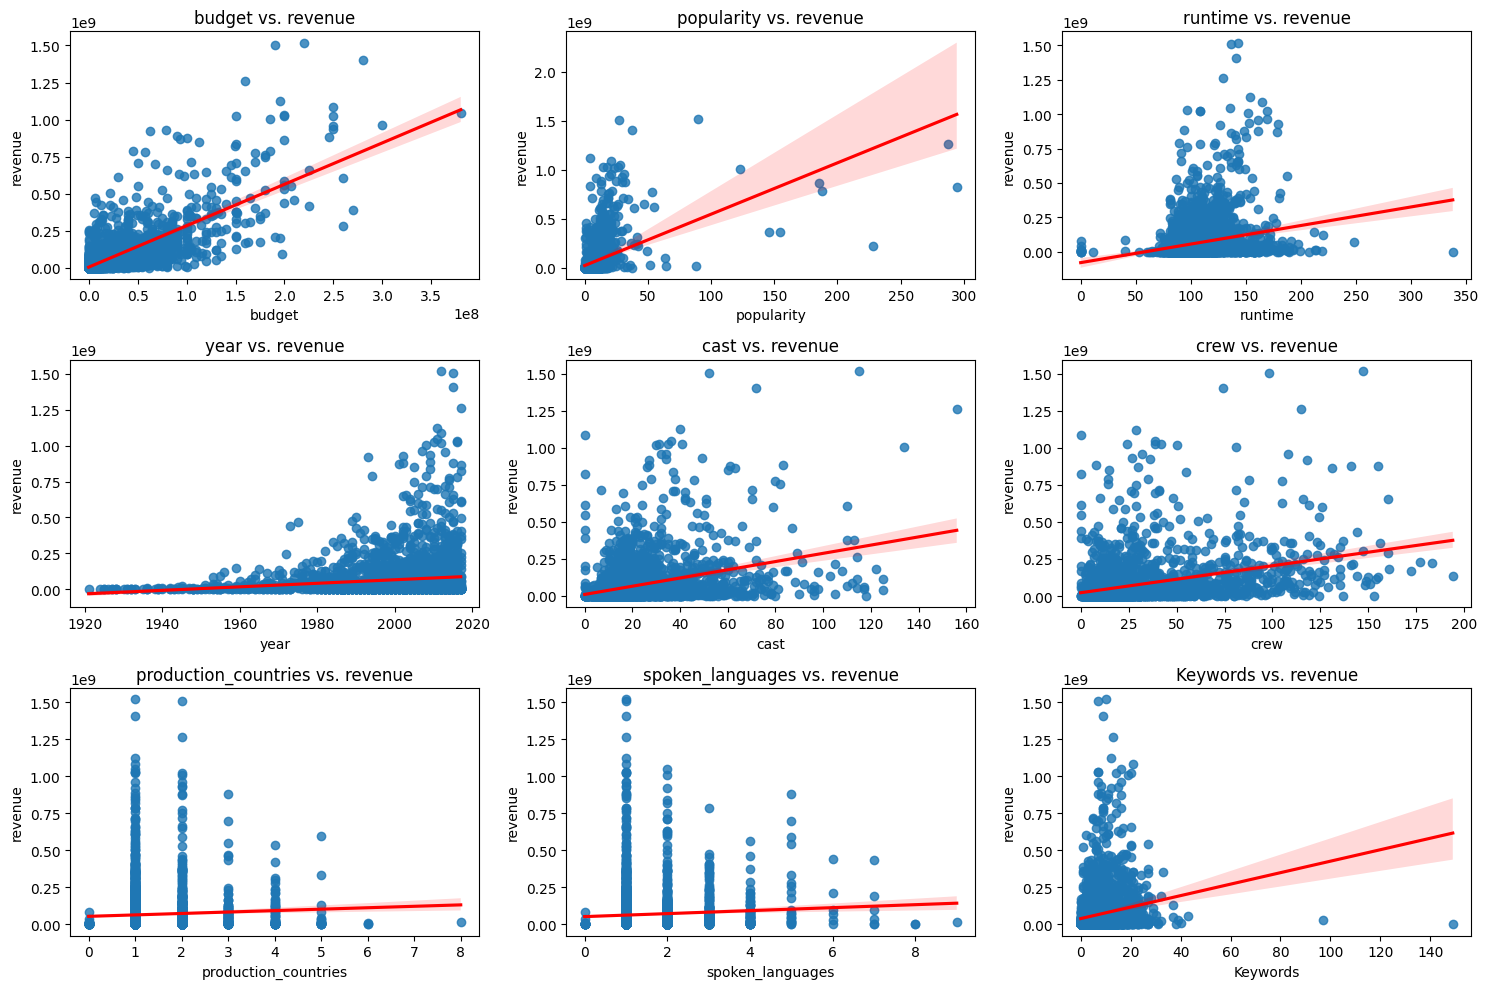

In [7]:
# List of columns to create scatter plots for
columns_to_plot = [
    'budget', 'popularity', 'runtime', 'year', 'cast', 'crew', 'production_countries', 'spoken_languages', 'Keywords'
]

# Calculate the number of rows and columns for the subplots
num_columns = 3
num_rows = (len(columns_to_plot) + num_columns - 1) // num_columns

# Create subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 10))

# Flatten the axes array for easier iteration
axes = axes.ravel()

# Create scatter plots for each column against 'revenue' with the correlation line
for i, column in enumerate(columns_to_plot):
    sns.regplot(x=train_df[column], y=train_df['revenue'], ax=axes[i], line_kws={"color": "red"})
    axes[i].set_title(f'{column} vs. revenue')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('revenue')

# Remove any empty subplots if the number of plots is not a multiple of 3
for i in range(len(columns_to_plot), num_rows * num_columns):
    fig.delaxes(axes[i])

# Show the plot
plt.tight_layout()
plt.show()

* Budsjett er tilknyttet omsetning.
* Popularitet er tilknyttet omsetning.
* Filmer som ikke har ideel runtime har lav omsetning.
* Omsetningen har steget med årene.
* Antall skuespillere/produksjon er tilknyttet omsetning.
* Antall land filmen er produsert i, og språk, er svakt tilknyttet omsetning.
* Antall keywords ser ut til å være tilknyttet omsetning.


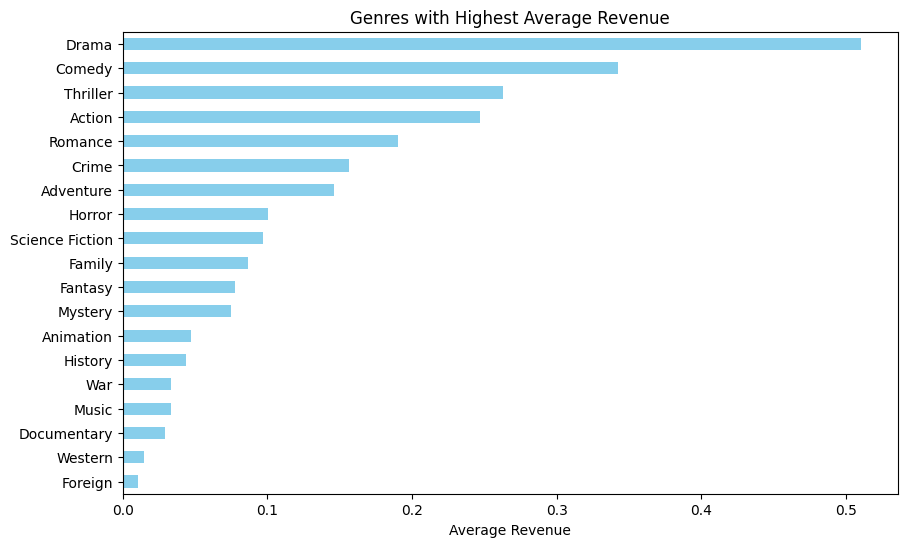

In [8]:
# Calculate the average revenue for columns
avg_revenue = train_df.iloc[:, 17:36].mean()

# Plot the top 10 columns horizontally
avg_revenue.sort_values().plot(kind='barh', figsize=(10, 6), color='skyblue')
plt.xlabel('Average Revenue')
plt.title('Genres with Highest Average Revenue')
plt.show()

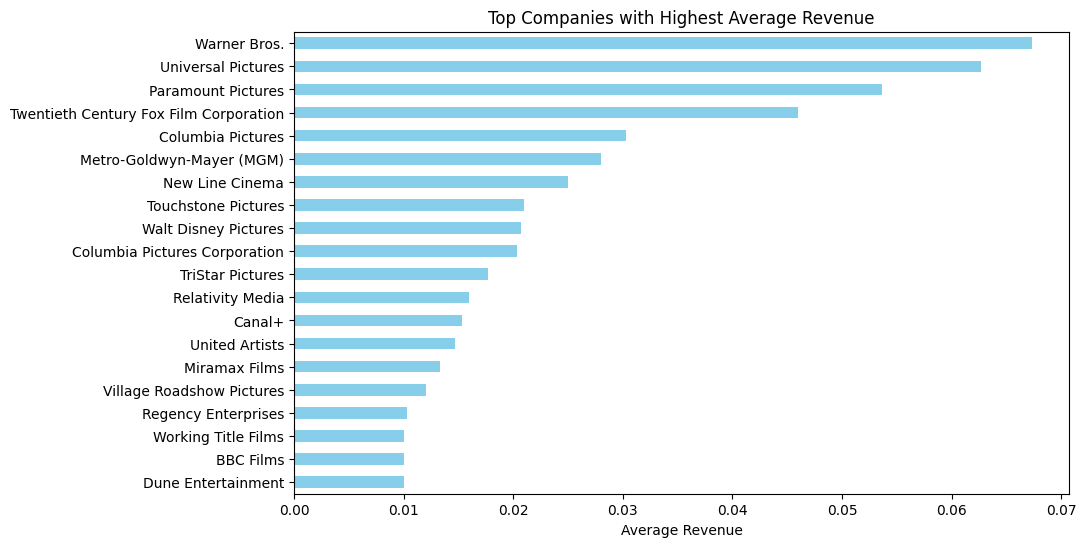

In [9]:
# Calculate the average revenue for columns
avg_revenue = train_df.iloc[:, 37:-1].mean()

# Select top 10 columns with the highest average revenue
top = avg_revenue.nlargest(20)

# Plot the top columns horizontally
top.sort_values().plot(kind='barh', figsize=(10, 6), color='skyblue')
plt.xlabel('Average Revenue')
plt.title('Top Companies with Highest Average Revenue')
plt.show()

# Velger features

In [10]:
def feature_selection(df):
    
    # Fjerner features som ikke forbedrer modellen
    df.drop(['id', 'homepage', 'tagline', 'Keywords', 'production_countries', 'spoken_languages', 'cast', 'crew',
             'month', 'day', 'english', 'us_production'], axis=1, inplace=True)
    
    return df

train_df = feature_selection(train_df)
train_df.head()

,belongs_to_collection,budget,popularity,runtime,year,Action,Science Fiction,Music,Romance,Foreign,...,Davis Entertainment,Wildwood Enterprises,Millennium Films,Screen Gems,Hollywood Pictures,Wild Bunch,Metro-Goldwyn-Mayer (MGM),Spyglass Entertainment,United Artists,revenue
0,1,14000000,6.575393,93.0,2015,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,12314651
1,1,40000000,8.248895,113.0,2004,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,95149435
2,0,3300000,64.299990,105.0,2014,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13092000
3,0,1200000,3.174936,122.0,2012,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,16000000
4,0,0,1.148070,118.0,2009,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3923970


# Trener modell

In [11]:
# Trener modell på all data.
X_train = train_df.to_numpy()[:, :-1]
model = RandomForestRegressor().fit(X_train, y_train)

rmsle_scorer = make_scorer(rmsle, greater_is_better=True)

cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=rmsle_scorer, n_jobs=-1)

print(cv_scores)
print(cv_scores.mean())

[2.56700677 2.49897536 2.3990612  2.59414006 2.26246614]
2.464329904983527


* Den nye modellen skårer 2,46 i RMSLE.
* Det er en forbedring, men det viser seg at det er vanskelig å finne verdifulle features og unngå overfitting.

# Deployment
https://huggingface.co/spaces/600880stud/revenueEstimator[]

# Behandler testdata

In [12]:
# Behandler
test_df_sub = data_preparation(test_df)
test_df_sub = feature_selection(test_df_sub)

columns_to_drop = [col for col in test_df_sub.columns if col not in train_df.columns]
test_df_sub.drop(columns=columns_to_drop, inplace=True)

missing_columns = [col for col in train_df.columns if col not in test_df_sub.columns]
test_df_sub = test_df_sub.reindex(columns=list(test_df_sub.columns) + missing_columns, fill_value=0)

# Estimerer
X_test = test_df_sub.to_numpy()[:, :-1]
test_df['revenue'] = model.predict(X_test)

# Testfil
submission = test_df[['id', 'revenue']]
submission.to_csv('submission.csv', index=False)